### 코드 요약
- 해당 코드은 reference temperature (T0)에서의 k값을 찾는 코드임
- 글리세롤 탈수소화 반응의 kinetic parameters를 추정함
- 반응과정에서 기체가 발생 + 수증기 발생 억제를 위한 가압조건에서의 반응으로 mass balance 함수에 이를 해석하는 수식이 포함되어 있음 (일반 기상반응은 더 단순함)

In [12]:
# 코드해석에 필요한 module 로드
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl



In [13]:
# kinetic data 로드
df = pd.read_csv('data.csv')
df1 = df[df['label']=='time'] # 시간 변수 데이터만 dataframe에 추출

In [14]:
# parameters initialization
Wi = 66.625 # 초기 반응물 질량 (g)
VL = 41.253968 # 초기 액상 부피 (mL)

# H2 solubility parameters
p00 = 0.2638
p01 = 5.443e-4
p02 = -2.45e-7
p10 = -1.545e-3
p20 = 2.205e-6
p11 = 9.105e-7

mw_h2o = 18 # g/mol, water molweight
mw_h2 = 2 # g/mol, hydrogen molweight

In [15]:
# 초기 농도 변수 할당
N0 = np.array([
    df1.iloc[0]['N_Gly [mmol]'],    # 글리세롤
    df1.iloc[0]['N_KOH [mmol]'],    # KOH
    df1.iloc[0]['N_H2 [mmol]'],     # 수소
    df1.iloc[0]['N_LA [mmol]'],     # 젖산
    df1.iloc[0]['N_PDO [mmol]'],    # 1,3-PDO
    df1.iloc[0]['N_FA [mmol]'],     # 포름산
    df1.iloc[0]['N_GA [mmol]'],     # 글리콜산
    df1.iloc[0]['N_ME [mmol]'],     # 메탄올
    df1.iloc[0]['N_EG [mmol]']      # 에틸렌글리콜
], dtype=np.float32)

# 실험 데이터 변수 할당
N_exp = np.array([
    df1.iloc[0:]['N_Gly [mmol]'].values,    # 글리세롤 0
    df1.iloc[0:]['N_KOH [mmol]'].values,    # KOH 1
    df1.iloc[0:]['N_H2 [mmol]'].values,     # 수소 2
    df1.iloc[0:]['N_LA [mmol]'].values,     # 젖산 3
    df1.iloc[0:]['N_PDO [mmol]'].values,    # 1,3-PDO 4
    df1.iloc[0:]['N_FA [mmol]'].values,     # 포름산 5
    df1.iloc[0:]['N_GA [mmol]'].values,     # 글리콜산 6
    df1.iloc[0:]['N_ME [mmol]'].values,     # 메탄올 7
    df1.iloc[0:]['N_EG [mmol]'].values      # 에틸렌글리콜 8
], dtype=np.float32)

In [16]:
def ode_system(t, N, k_params):
    '''반응기 내부의 mass balance를 계산하는 미분방정식 설정'''

    wcat = 0.3*0.02 # Pt 함량 0.3 g의 2%

    VL = 41.253968 # mL (연산 편의를 위해 액상 부피를 고정함)
    VG = 145 - VL # 기상 부피
    C = N/VL # mmol/mL = M
    

    
    T = 200.0 # 반응 온도
    P_H2O = 10**(8.14019-1810.94/(244.485+T))/750.062 # Antoine equation, H2O 증기압 계산
    vg = 8.314*(T+273.15)/(P_H2O*1e5) # H2O 기체 부피
    NG_H2O = 1/(vg*1e3)*VG # H2O 기체 몰수

    P_H2 = (N[2]/1e3)/(VG/1e6)*8.314*(T+273.15)/1e5 # H2 부분압력
    S_H2 = p00 + (T)*p10 + P_H2*p01 + (T)**2*p20 + P_H2**2*p02 + (T)*P_H2*p11 # H2 용해도
    WL = Wi - (N[2])*mw_h2/1000 - NG_H2O*mw_h2o/1000 # 액상 무게
    NL_H2 = S_H2*WL # H2 용해 몰수
    NLf_H2 = min(N[2], NL_H2) # H2 용해도 * 액상 무게 중 작은 값

    C[2] = NLf_H2/VL
        # C의 0인 성분을 1e-8로 수정, 수렴성 개선
    C[C < 0] = 1e-8
    # kg1 0 # KGly 1 # KH2 2 # KPDO 3 # kd1 4 # kd2 5 # kd3 6 # kp1 7 # kp2 8

    # 글리세롤 0 # KOH 1 # 수소 2 # 젖산 3 # 1,3-PDO 4 # 포름산 5 # 글리콜산 6 # 메탄올 7 # 에틸렌글리콜 8
    
    # parameter
    k = 10**k_params
    
    # Intensive reaction rate
    theta = 1 + k[1]*C[0] + (k[2]*C[2])**0.5 + k[3]*C[4]
    rg1= k[0]*k[1]*C[0]/(theta**3) # Glycerol -> DHA + H2
    rd1 = k[4] # DHA -> PRA + H2O
    rd2 = k[5]*(C[1]**2) # DHA + 2KOH -> FA + GA + 2H2
    rd3 = k[6]*(C[2]**2) # DHA + 2H2 -> ME + EG
    rp1 = k[7]*C[1] # PRA + KOH -> LA
    rp2 = k[8]*k[2]**2*C[2]**2/(theta**5)# PRA + 2H2 -> PDO

    # Extensive reaction rate
    rg1_ext = rg1*wcat
    rd1_ext = rd1*VL/1000
    rd2_ext = rd2*VL/1000
    rd3_ext = rd3*VL/1000
    rp1_ext = rp1*VL/1000
    rp2_ext = rp2*wcat

    # Fractional conversion
    fd1 = rd1_ext/(rd1_ext+rd2_ext+rd3_ext)
    fd2 = rd2_ext/(rd1_ext+rd2_ext+rd3_ext)
    fd3 = rd3_ext/(rd1_ext+rd2_ext+rd3_ext)

    fp1 = rp1_ext/(rp1_ext+rp2_ext)
    fp2 = rp2_ext/(rp1_ext+rp2_ext)

    # Mass balance
    dN0dt = -rg1_ext
    dN1dt = -2*rg1_ext*fd2 - rg1_ext*fd1*fp1
    dN2dt = rg1_ext + 2*rg1_ext*fd2 - 2*rg1_ext*fd3 - 2*rg1_ext*fd1*fp2
    dN3dt = rg1_ext*fd1*fp1
    dN4dt = rg1_ext*fd1*fp2
    dN5dt = rg1_ext*fd2
    dN6dt = rg1_ext*fd2
    dN7dt = rg1_ext*fd3
    dN8dt = rg1_ext*fd3

    return np.array([dN0dt, dN1dt, dN2dt, dN3dt, dN4dt, dN5dt, dN6dt, dN7dt, dN8dt])


In [17]:
# 시간 변수 할당
t_eval = np.array(df1.iloc[0:]['Time [h]'].values, dtype=np.float32)

In [18]:
# Mass balance 함수 계산을 위한 Runge-Kutta 4th order method
def solve_ode(k_params, t_eval, y0):
    sol = solve_ivp(
        ode_system,
        t_span=(t_eval[0], t_eval[-1]),
        y0=y0,
        t_eval=t_eval,
        args=(k_params,),
        method='RK45'
    )
    return sol.y

In [19]:
# kinetic parameter 최적화를 위한 함수
def objective_function(k_params):
    try:
        N_pred = solve_ode(k_params, t_eval, N0)
        
        # 마스킹할 데이터 위치 정의: 실험값의 이상치는 loss에 반영 X
        mask = np.ones_like(N_exp, dtype=bool)
        mask[4,-1] = False  # t=2.5에서의 PDO
        mask[7,4] = False   # t=2에서의 ME 
        mask[8,4] = False   # t=2에서의 EG
        mask[5,-1] = False  # t=2.5에서의 FA
        
        # 각 성분별 최대값으로 normalize
        N_exp_max = np.max(np.abs(N_exp), axis=1)
        N_exp_max = np.where(N_exp_max == 0, 1, N_exp_max)  # 0으로 나누기 방지
        
        # normalize된 error 계산 (마스킹 적용)
        squared_errors = ((N_pred - N_exp) / N_exp_max.reshape(-1,1))**2
        normalized_error = np.mean(squared_errors[mask])
        return normalized_error
    except:
        return 1e10

In [ ]:
best_loss = float('inf')
best_x = np.ones(9)
x0 = np.ones(9)
for i in range(100):  # 10번 반복
    result = minimize(
        objective_function,
        x0=x0,
        method='L-BFGS-B',
        bounds=[(-20, 20) for _ in range(len(x0))]  # 모든 변수에 대해 -10 ~ 10 범위 제한
    )
    
    # 현재 시도의 loss 출력
    print(f'시도 {i+1} - Loss: {result.fun:.6f}, Best Loss: {best_loss:.6f}')
    
    if result.fun < best_loss:
        best_loss = result.fun
        best_x = result.x.copy()
        x0 = result.x.copy()  # 더 나은 결과를 얻은 경우 x0를 result.x로 갱신
    else:
        x0 = best_x.copy()  # 더 나은 결과를 얻지 못한 경우 best_x를 x0로 사용
        
    # x0에 랜덤 변화 추가
    x0 = x0 * (1 + np.random.randn(len(x0)) * 0.1)


시도 1 - Loss: 0.485110, Best Loss: inf
시도 2 - Loss: 0.485110, Best Loss: 0.485110
시도 3 - Loss: 0.485110, Best Loss: 0.485110
시도 4 - Loss: 0.485110, Best Loss: 0.485110
시도 5 - Loss: 0.485111, Best Loss: 0.485110
시도 6 - Loss: 0.485110, Best Loss: 0.485110
시도 7 - Loss: 0.485110, Best Loss: 0.485110
시도 8 - Loss: 0.485110, Best Loss: 0.485110
시도 9 - Loss: 0.485108, Best Loss: 0.485110
시도 10 - Loss: 0.485106, Best Loss: 0.485108
시도 11 - Loss: 0.485107, Best Loss: 0.485106
시도 12 - Loss: 0.485106, Best Loss: 0.485106
시도 13 - Loss: 0.485104, Best Loss: 0.485106
시도 14 - Loss: 0.485104, Best Loss: 0.485104
시도 15 - Loss: 0.485103, Best Loss: 0.485104
시도 16 - Loss: 0.485105, Best Loss: 0.485103
시도 17 - Loss: 0.003972, Best Loss: 0.485103
시도 18 - Loss: 0.003972, Best Loss: 0.003972
시도 19 - Loss: 0.003918, Best Loss: 0.003972
시도 20 - Loss: 0.034196, Best Loss: 0.003918
시도 21 - Loss: 0.003908, Best Loss: 0.003918
시도 22 - Loss: 0.003611, Best Loss: 0.003908
시도 23 - Loss: 0.003611, Best Loss: 0.003611
시도

In [21]:
result.x

array([14.437292  , -7.90854401,  0.69282457, -2.81867492,  2.19468063,
       -0.90977553,  1.90429212, -0.0208066 ,  2.28021932])

In [22]:
best_x

array([13.31227491, -8.58080879,  0.65369337, -2.91441592,  2.08739685,
       -0.97210174,  1.95869489,  0.02540592,  2.48093308])

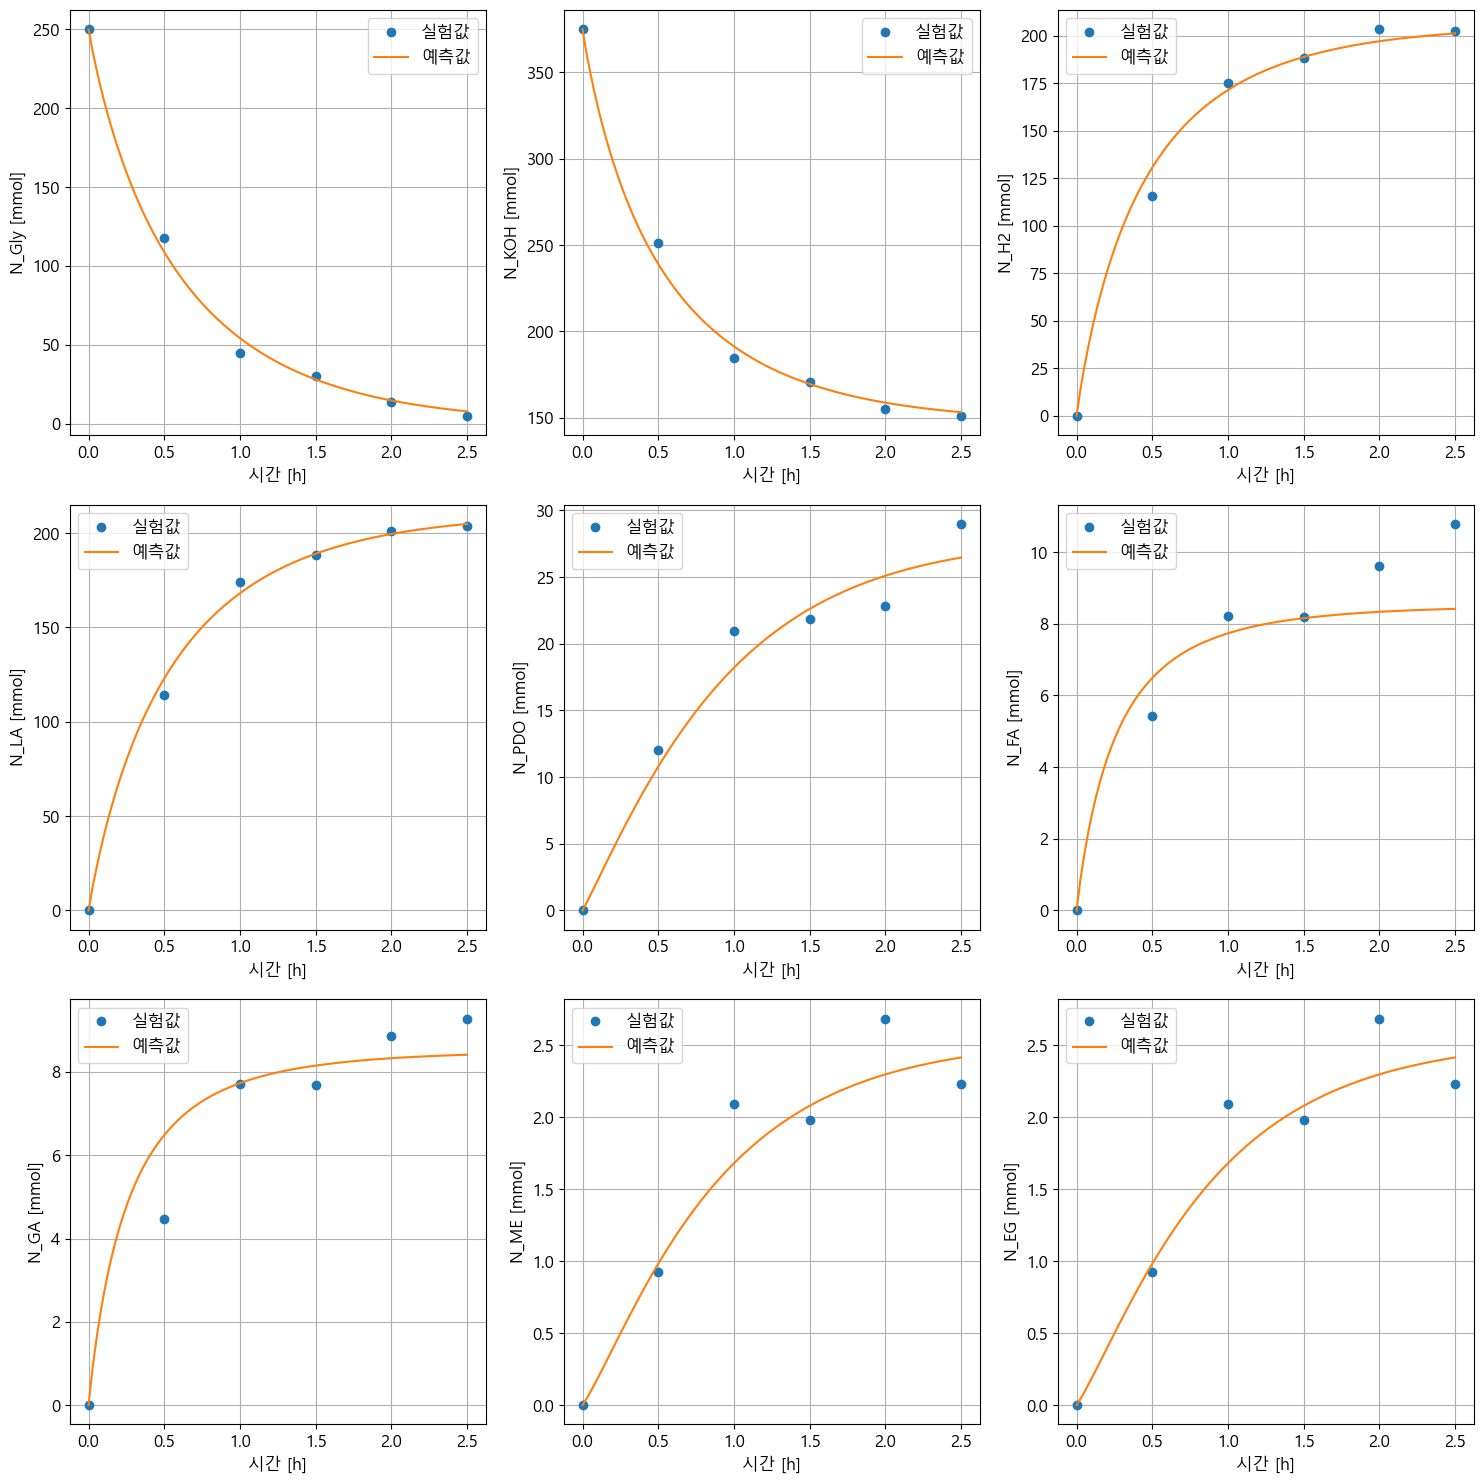

In [25]:
# 한글 폰트 깨짐 방지 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 예측값 계산을 위한 더 조밀한 시간 격자 생성
t_pred = np.linspace(t_eval[0], t_eval[-1], 100)
N_pred = solve_ode(best_x, t_pred, N0)

# 성분별 비교 그래프 그리기
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
components = ['Gly', 'KOH', 'H2', 'LA', 'PDO', 'FA', 'GA', 'ME', 'EG']

for i, (ax, comp) in enumerate(zip(axes.flat, components)):
    ax.plot(t_eval, N_exp[i], 'o', label='실험값')
    ax.plot(t_pred, N_pred[i], '-', label='예측값')
    ax.set_xlabel('시간 [h]')
    ax.set_ylabel(f'N_{comp} [mmol]')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [24]:
result.fun

np.float64(0.03419567210171269)